# EEG States
Training a model on manually labelled EEG data to find various states.

In [72]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)


# Load data

In [73]:
input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")


In [74]:
from models.eeg_states.eeg_states import load_events, load_and_prepare_eeg_state_events

nights = load_and_prepare_eeg_state_events()

C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-10-09 20:17:27.992000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:83: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [75]:
nights

,event,timestamp,since,duration,TimestampUK,SinceUK,dayAndNightOf
0,tired_long,2024-10-09 20:22:27.992000+00:00,2024-10-09 20:17:27.992000+00:00,0 days 00:05:00,2024-10-09 21:22:27.992000+01:00,2024-10-09 21:17:27.992000+01:00,2024-10-09
1,tired,2024-10-09 20:28:57.046000+00:00,NaT,NaT,2024-10-09 21:28:57.046000+01:00,NaT,2024-10-09
2,tired,2024-10-09 20:32:36.824000+00:00,NaT,NaT,2024-10-09 21:32:36.824000+01:00,NaT,2024-10-09
3,tired_long,2024-10-09 20:32:52.775000+00:00,2024-10-09 20:32:36.824000+00:00,0 days 00:00:15.951000,2024-10-09 21:32:52.775000+01:00,2024-10-09 21:32:36.824000+01:00,2024-10-09
4,tired,2024-10-09 20:33:13.921000+00:00,NaT,NaT,2024-10-09 21:33:13.921000+01:00,NaT,2024-10-09
...,...,...,...,...,...,...,...
262,tired,2024-11-12 21:42:24.990000+00:00,NaT,NaT,2024-11-12 21:42:24.990000+00:00,NaT,2024-11-12
263,tired_long,2024-11-12 21:43:03.382000+00:00,2024-11-12 21:42:24.990000+00:00,0 days 00:00:38.392000,2024-11-12 21:43:03.382000+00:00,2024-11-12 21:42:24.990000+00:00,2024-11-12
264,tired,2024-11-12 21:43:03.542000+00:00,NaT,NaT,2024-11-12 21:43:03.542000+00:00,NaT,2024-11-12
265,tired,2024-11-12 22:49:16.227000+00:00,NaT,NaT,2024-11-12 22:49:16.227000+00:00,NaT,2024-11-12


In [76]:
for i in range(len(nights) - 1):
    if nights.loc[i, 'event'] == 'wired' and nights.loc[i + 1, 'event'] == 'tired':
        ts = nights.loc[i, 'TimestampUK']
        print(f"Wired event at index {i} {ts} is right next to a tired event at index {i + 1}")

Wired event at index 24 2024-10-10 06:38:03.185000+01:00 is right next to a tired event at index 25
Wired event at index 51 2024-10-20 20:51:41.078000+01:00 is right next to a tired event at index 52


## Load other data

In [77]:
import os

dfs = []

for root, dirs, files in os.walk(input_dir):
    for idx, dir_name in enumerate(dirs):
        input_file = os.path.join(root, dir_name, "raw.post_human.csv")
        if os.path.exists(input_file):
            df = pd.read_csv(input_file)
            dfs.append(df)

yasa_df = pd.concat(dfs, ignore_index=True)

In [78]:
yasa_df_orig = yasa_df.copy()
assert yasa_df.index.is_unique, "Index is not unique"

In [79]:
yasa_df.shape

(66508, 1625)

In [80]:
yasa_df['dayAndNightOf'].value_counts()

dayAndNightOf
2024-09-24    2083
2024-08-19    1848
2024-09-03    1780
2024-08-20    1502
2024-10-11    1389
              ... 
2024-09-16     314
2024-07-08     310
2024-10-29     135
2024-11-03     105
2024-10-20      83
Name: count, Length: 62, dtype: int64

# Prepare data - find if in state

In [81]:
from sleep_events import convert_timestamps_to_uk

convert_timestamps_to_uk(yasa_df, 'Timestamp', 'TimestampUK')

In [82]:
yasa_df['TimestampUK']

0       2024-07-08 22:51:16.763590097+01:00
1       2024-07-08 22:51:46.763590097+01:00
2       2024-07-08 22:52:16.763590097+01:00
3       2024-07-08 22:52:46.763590097+01:00
4       2024-07-08 22:53:16.763590097+01:00
                        ...                
66503   2024-11-08 07:46:18.485414982+00:00
66504   2024-11-08 07:46:48.485414982+00:00
66505   2024-11-08 07:47:18.485414982+00:00
66506   2024-11-08 07:47:48.485414982+00:00
66507   2024-11-08 07:48:18.485414982+00:00
Name: TimestampUK, Length: 66508, dtype: datetime64[ns, Europe/London]

In [83]:
from models.eeg_states.eeg_states import process_row
import pandas as pd
from tqdm import tqdm

# Pre-filter the data as it takes ages
first_timestamp_uk = nights['TimestampUK'].min()
filtered_yasa_df = yasa_df[yasa_df['TimestampUK'] >= first_timestamp_uk]

# Add new columns to yasa_df to store the epoch type
yasa_df = filtered_yasa_df.copy() # defragment
yasa_df['epoch_type'] = None
yasa_df['matched_night_event'] = None

# Iterate over each row in yasa_df
for i, yasa_row in tqdm(yasa_df.iterrows(), total=yasa_df.shape[0]):
    epoch_type, matched_night_event = process_row(yasa_row, nights)
    yasa_df.at[i, 'epoch_type'] = epoch_type
    yasa_df.at[i, 'matched_night_event'] = matched_night_event

100%|██████████| 13940/13940 [02:03<00:00, 113.27it/s]


In [84]:
yasa_df['epoch_type'].value_counts()

epoch_type
tired    116
wired     22
Name: count, dtype: int64

In [85]:
from memory import garbage_collect

garbage_collect(log)

In [86]:
from models.eeg_states.eeg_states_model import model_pipeline

models_and_data = [
    model_pipeline('non-realtime', yasa_df, "epoch_type", False),
    model_pipeline('realtime', yasa_df, "epoch_type", True),
]

['Main_eeg_abspow_s', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_at_c7min_norm_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_auc_c7min_norm_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_beta_c7min_norm_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_betaabs_c7min_norm_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_db_c7min_norm_s', 'Main_eeg_

In [87]:
from models.eeg_states.eeg_states_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.2, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training set size non-realtime: 110, validation set size: 28
Training set size realtime: 110, validation set size: 28


# Train Catboost model

In [88]:
from catboost import CatBoostClassifier

def train(md: ModelAndData):
    md.model = CatBoostClassifier(
        eval_metric='Logloss',    
        loss_function='CrossEntropy',
        iterations=2000,                # Number of boosting iterations
        learning_rate=0.03,             # Learning rate
        depth=6,                        # Depth of the tree
        l2_leaf_reg=3,                  # L2 regularization term on weights
        early_stopping_rounds=50        # Early stopping rounds
    )

    log(f"Training model for {md.name}")
    md.model.fit(md.X_train, md.y_train, verbose=100)

for md in models_and_data:
    train(md)

0:	learn: 0.6677935	total: 11.9ms	remaining: 23.8s
100:	learn: 0.0475963	total: 719ms	remaining: 13.5s
200:	learn: 0.0135723	total: 1.49s	remaining: 13.3s
300:	learn: 0.0070702	total: 2.16s	remaining: 12.2s
400:	learn: 0.0048198	total: 2.84s	remaining: 11.3s
500:	learn: 0.0036328	total: 3.49s	remaining: 10.5s
600:	learn: 0.0029618	total: 4.15s	remaining: 9.66s
700:	learn: 0.0025323	total: 4.72s	remaining: 8.76s
800:	learn: 0.0022599	total: 5.21s	remaining: 7.8s
900:	learn: 0.0020674	total: 5.69s	remaining: 6.94s
1000:	learn: 0.0019236	total: 6.19s	remaining: 6.18s
1100:	learn: 0.0018161	total: 6.67s	remaining: 5.44s
1200:	learn: 0.0017359	total: 7.17s	remaining: 4.77s
1300:	learn: 0.0016625	total: 7.64s	remaining: 4.11s
1400:	learn: 0.0016230	total: 8.11s	remaining: 3.47s
1500:	learn: 0.0015906	total: 8.55s	remaining: 2.84s
1600:	learn: 0.0015703	total: 8.99s	remaining: 2.24s
1700:	learn: 0.0015452	total: 9.43s	remaining: 1.66s
1800:	learn: 0.0015207	total: 9.87s	remaining: 1.09s
1900:

## Evaluate the model

Evaluation for model:  non-realtime
non-realtime Training Set Evaluation:
non-realtime Mean Absolute Error (MAE): 0.0
non-realtime Mean Squared Error (MSE): 0.0
non-realtime Root Mean Squared Error (RMSE): 0.0
non-realtime Validation Set Evaluation:
non-realtime Mean Absolute Error (MAE): 0.10714285714285714
non-realtime Mean Squared Error (MSE): 0.10714285714285714
non-realtime Root Mean Squared Error (RMSE): 0.32732683535398854


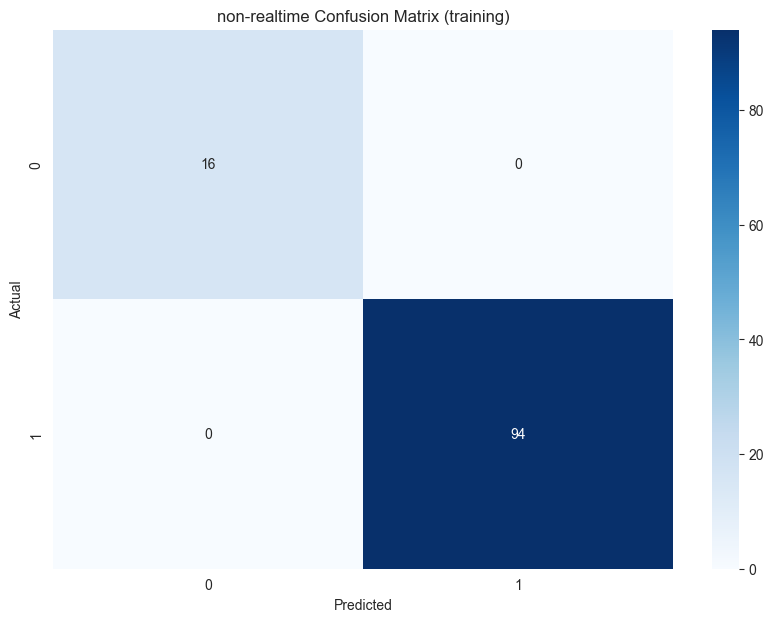

[0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1]


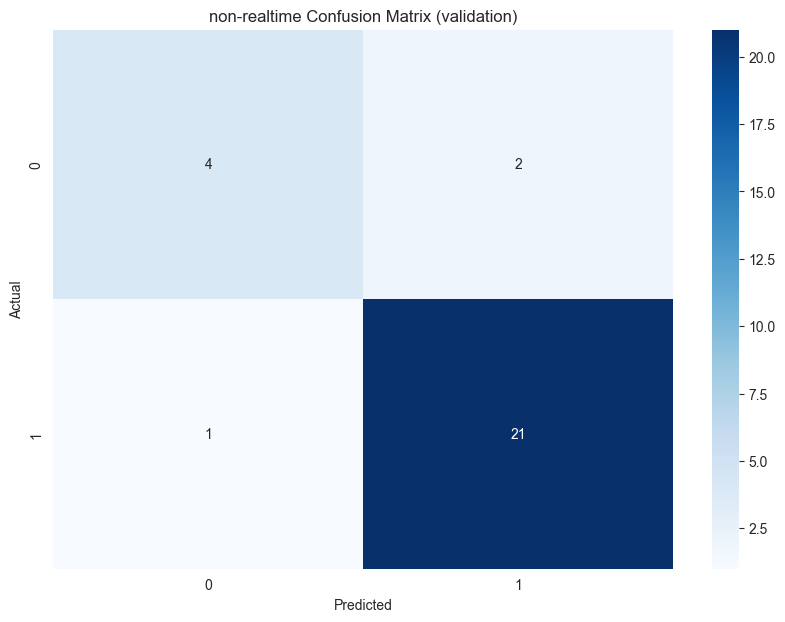

Evaluation for model:  realtime
realtime Training Set Evaluation:
realtime Mean Absolute Error (MAE): 0.0
realtime Mean Squared Error (MSE): 0.0
realtime Root Mean Squared Error (RMSE): 0.0
realtime Validation Set Evaluation:
realtime Mean Absolute Error (MAE): 0.10714285714285714
realtime Mean Squared Error (MSE): 0.10714285714285714
realtime Root Mean Squared Error (RMSE): 0.32732683535398854


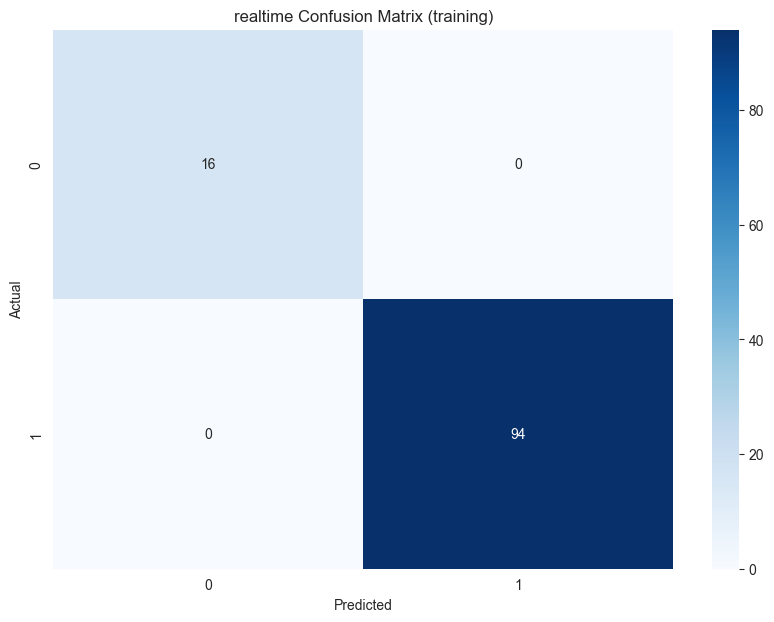

[1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1]


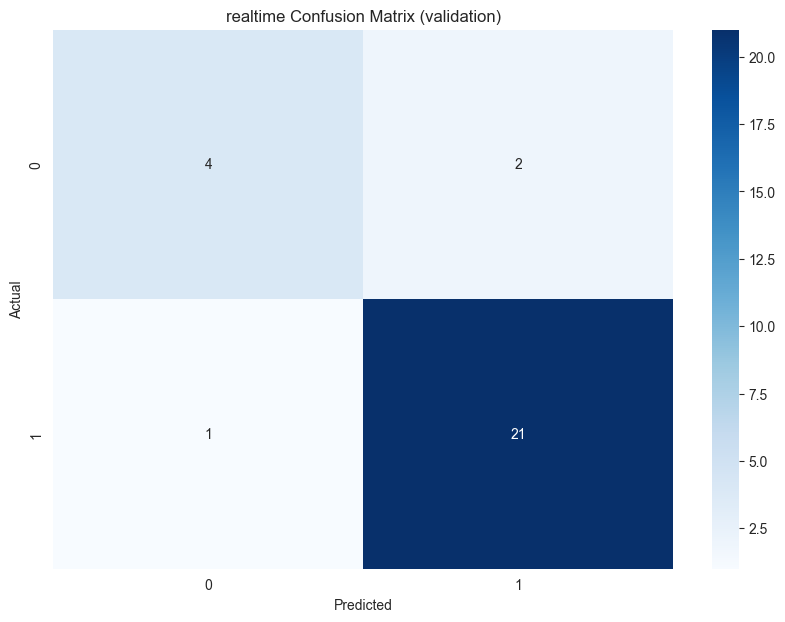

In [89]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(md: ModelAndData, model, X, y):
    # Predict the target values using the trained model
    predictions = model.predict(X)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"{md.name} Mean Absolute Error (MAE): {mae}")
    print(f"{md.name} Mean Squared Error (MSE): {mse}")
    print(f"{md.name} Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

def evaluate_classification_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)
    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_mae, train_mse, train_rmse = evaluate_model(md, model, X_train, y_train)
    
    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_mae, val_mse, val_rmse = evaluate_model(md, model, X_val, y_val)

    val_train = model.predict(X_train)

    train_results_df = pd.DataFrame({
        'Actual': y_train,
        'Predicted': val_train
    })

    cm_train = confusion_matrix(train_results_df['Actual'], train_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (training)')
    plt.show()

    
    # Predict the target values using the trained model
    val_predictions = model.predict(X_val)
    print(val_predictions)
    
    # Create a DataFrame with y_val and the predictions
    val_results_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': val_predictions
    })

    cm_val = confusion_matrix(val_results_df['Actual'], val_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (validation)')
    plt.show()
    
for md in models_and_data:
    evaluate_classification_model(md, md.X_train, md.y_train, md.X_val, md.y_val)
#eval2(model_to_ready_to_sleep, X_train_to_ready_to_sleep, y_train_to_ready_to_sleep, X_val_to_ready_to_sleep, y_val_to_ready_to_sleep)

## Most useful features

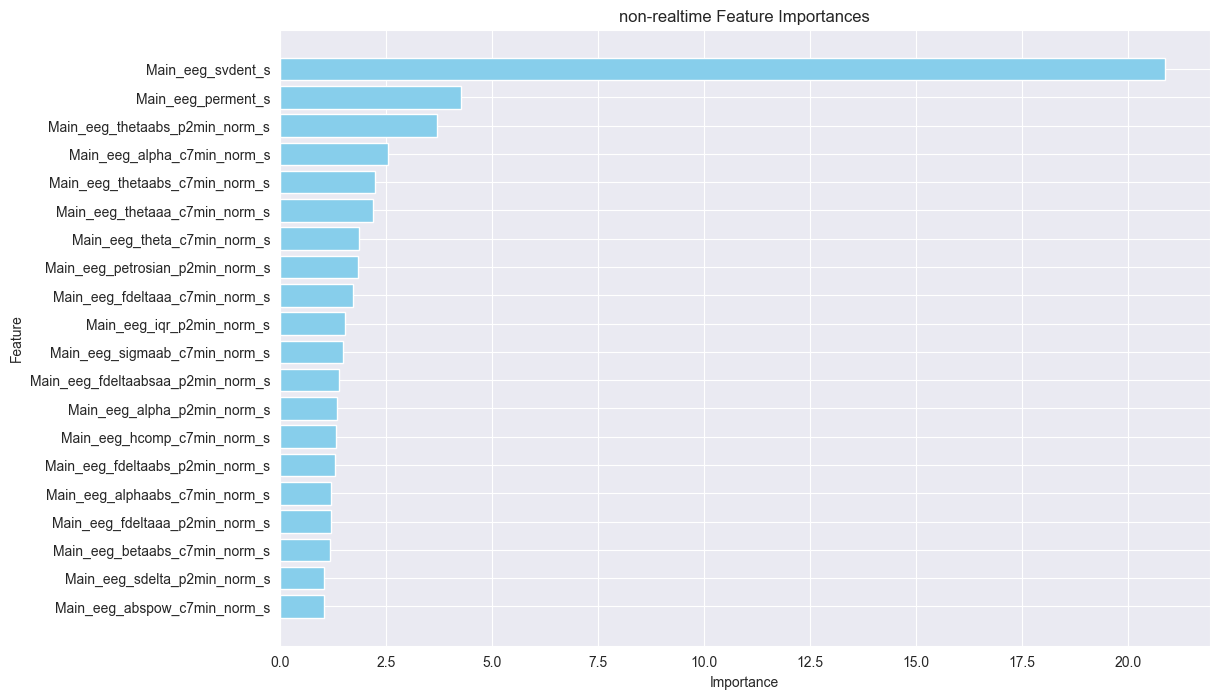

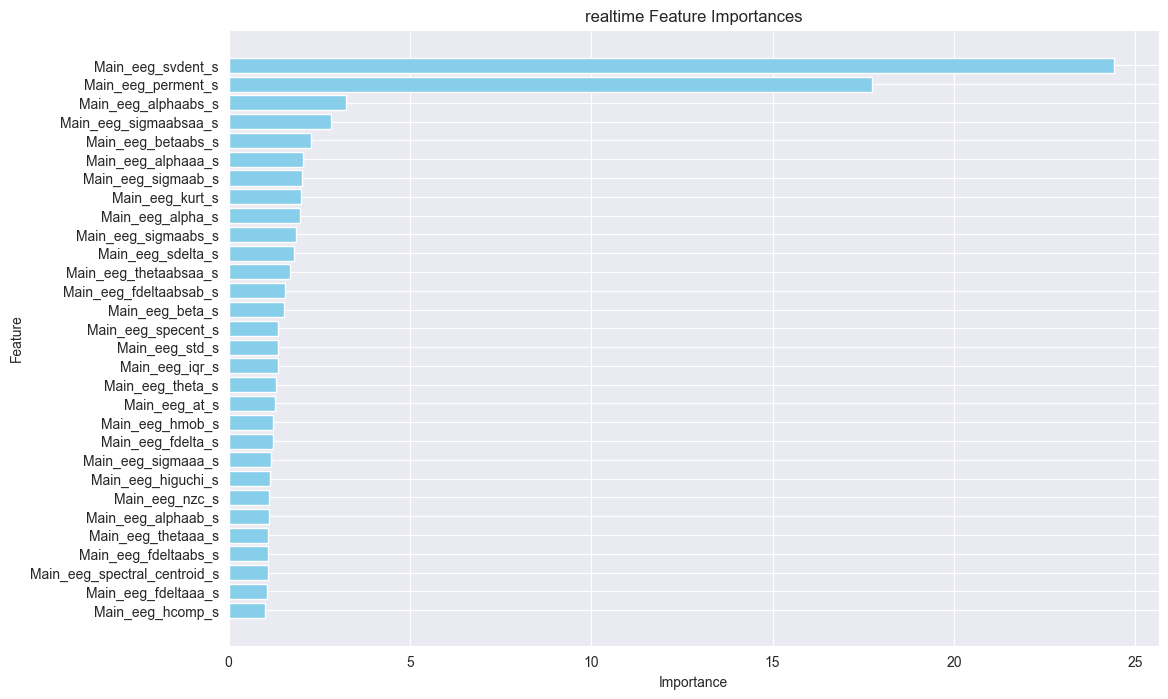

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

def importances(md: ModelAndData):
    # Get feature importances
    feature_importances = md.model.get_feature_importance()
    
    # Create a DataFrame to display the feature importances
    feature_names = md.X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df[importance_df['Importance'] > 1]
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(md.name + ' Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

for md in models_and_data:
    importances(md)

# Save model

In [91]:
for md in models_and_data:
    model_filename = f"{md.name}_catboost_model.cbm"
    md.model.save_model(model_filename)
    print(f"Model saved to {model_filename}")

Model saved to non-realtime_catboost_model.cbm
Model saved to realtime_catboost_model.cbm
